#Chip Calibration Example
## Setup
## Find the qubit
1. One tone spectroscopy (VNA)
2. Punch out
3. Chevron Pattern
## Single qubit calibration
4. Amplitude Rabi Oscillation
5. Time Rabi Oscillation
6. Ramsey
7. Stack X90
8. Drag Alpha
9. Readout frequency optimization by blob separation
9. Single qubit randomized benchmarking
## Two qubits gate calibration (CR/CNOT)
10. Cross resonance scan
11. Full XY scan
12. CNOT truth table
13. Two qubits RB

# Setup

In [181]:
chip='X6Y3'
chip='X4Y1'
chip='X4Y2'
board='huracan'
board='pinto'
print(board,chip)

pinto X4Y2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import json
import time
from scipy.optimize import curve_fit,fminbound

In [3]:
def rfswitch(board='huracan', chip='X6Y3'):
    import switchbox
    with open('swcfg.json') as jfile:
        swcfg=json.load(jfile)
    for sw,dest in swcfg['boardchip'][board][chip].items():
        switchbox.connect(url=swcfg['swurl'][sw],dest=dest)
    for sw in swcfg['swurl']:
        print(sw,switchbox.urlread(swcfg['swurl'][sw]))        
rfswitch(board,chip)

sw1 Connected ports: A-C, B-D
sw2 Connected ports: A-C, B-D


In [4]:
from distproc.hwconfig import FPGAConfig, load_channel_configs
import qubitconfig.qchip as qc
reload(qc)

qchippath='../chipcalibration/submodules/qchip/%s/%s/'%(chip,board)
qubic3serverport=dict(huracan=9096,pinto=9097)

fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 
                            'jump_cond_clks': 5, 'jump_fproc_clks': 5, 
                            'pulse_regwrite_clks': 3, 'pulse_load_clks': 4})
channel_configs = load_channel_configs(qchippath+'channel_config.json')
qchip = qc.QChip(qchippath+'qubitcfg.json')



In [5]:
if 0:
    import qubic.run
    runner = qubic.run.CircuitRunner(commit='f24f1615')

In [6]:
if 1:
    import qubic.rpc_client as rc
    reload(rc)
    runner = rc.CircuitRunnerClient(ip='192.168.1.25', port=qubic3serverport[board]) #huracan
#runner = rc.CircuitRunnerClient(ip='192.168.1.25', port=9097) #pinto

In [7]:
import qubic.job_manager as jm
reload(jm)
jobman = jm.JobManager(fpga_config, channel_configs, runner, qchip)

In [8]:
import qubic.state_disc as sd
gmm = sd.GMMManager(qchippath+'Q01gmm.pkl')
jobman.update_gmm(gmm)

# One tone Spectroscopy (VNA)

In [10]:
from chipcalibration import vna as vn
fstart=6.5e9
fstop=6.9e9
vna = vn.Vna(0.01, np.linspace(fstart, fstop, 300), 200)
vna.run_and_report(jobman)

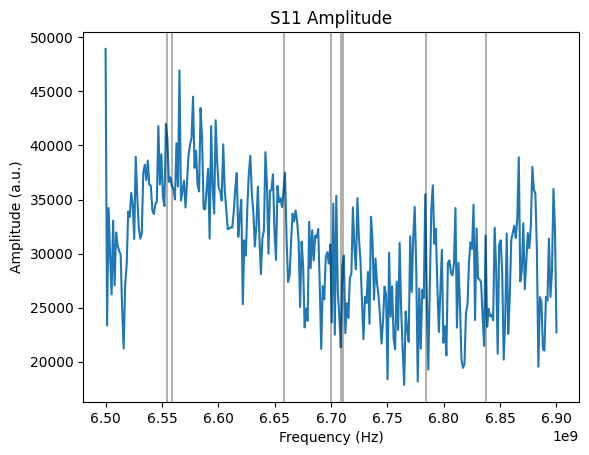

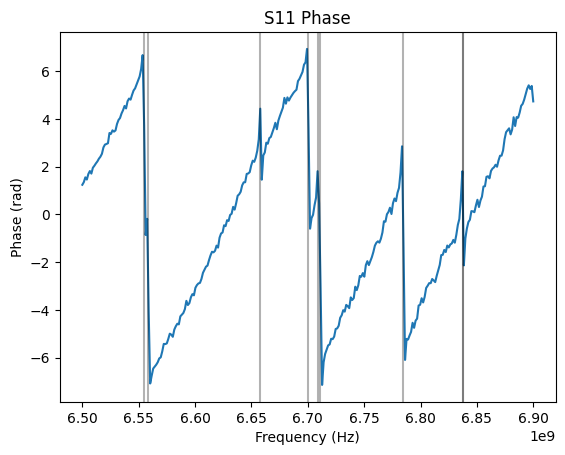

In [11]:
%matplotlib inline
qchip = qc.QChip(qchippath+'qubitcfg.json')

plt.plot(vna.freqs, vna.results['amp'])
for i in range(8):
    x=qchip.qubits['Q%d'%i].readfreq
    plt.axvline(x=x,color='black',alpha=0.3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (a.u.)')
plt.title('S11 Amplitude')
plt.show()
plt.plot(vna.freqs, vna.results['phase'])
for i in range(8):
    x=qchip.qubits['Q%d'%i].readfreq
    plt.axvline(x=x,color='black',alpha=0.3)
plt.axvline(x=x,color='black',alpha=0.3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')
plt.title('S11 Phase')
plt.show()

# Punchout

In [12]:
from chipcalibration import punchout as po
reload(po)
qubits = ['Q0','Q1']
#qubit_dict = punchout.get_qubit_dict(qubits, qchip)
punchout = po.Punchout(qchip, fpga_config, channel_configs, qubits, n_freq=300, freq_bandwidth=6.e6,
                       atten_start=10, atten_stop=40, atten_step=2)

In [13]:
punchout.run(runner)

Click any plot to select desired resonator attenuation and frequency. If this is not a resonator, click outside the plot to remove from config


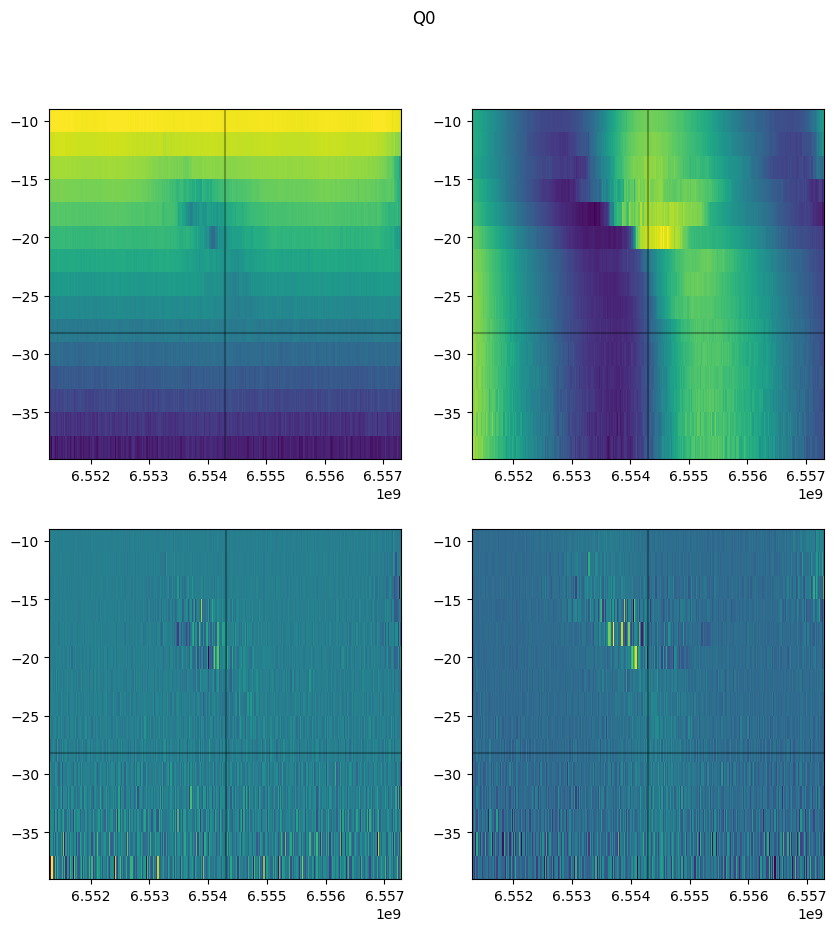

Click any plot to select desired resonator attenuation and frequency. If this is not a resonator, click outside the plot to remove from config


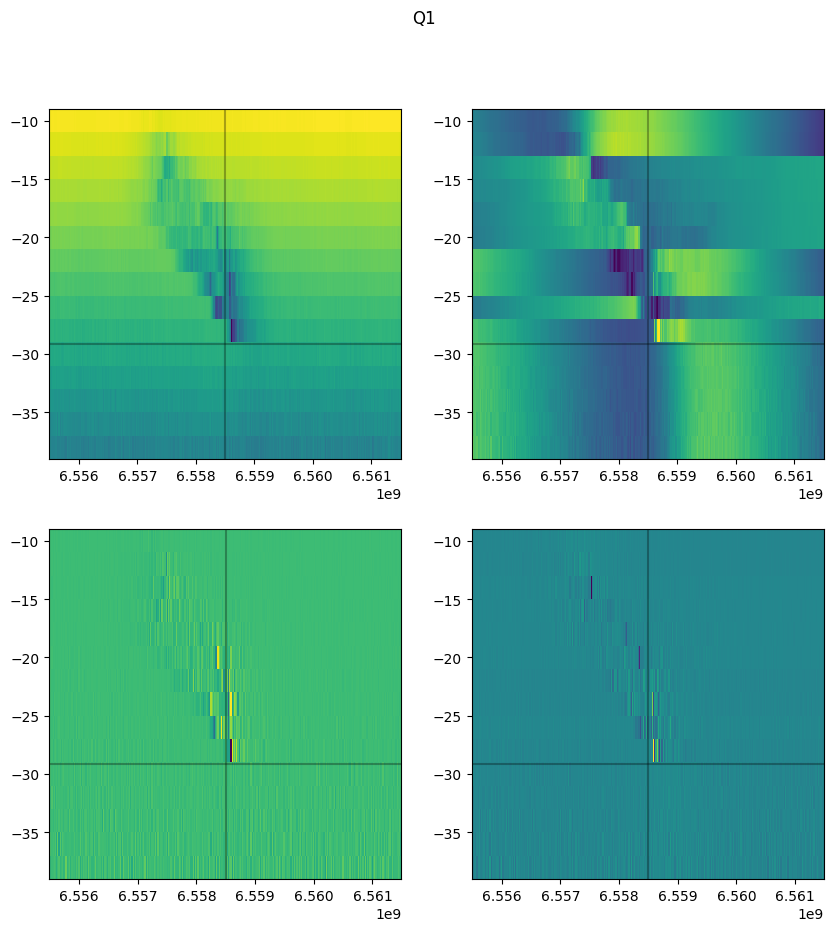

In [14]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
punchout.run_punchout_gui(qchip)

# Chevron 

In [15]:
from chipcalibration import chevron as ch
reload(ch)
qchip = qc.QChip(qchippath+'/qubitcfg.json')
qubits = ['Q0', 'Q1']
#qubits = ['Q1',]
nwidth = 40
pulse_widths = np.linspace(4.e-9, 500.e-9, nwidth)
nshot=20
nfreq = 40
fspan=20e6
centerfreq=None


In [16]:
for q in qubits:
    print(qchip.qubits[q].readfreq/1e6)
    print(qchip.gates[q+'rabi_drag'].cfg_dict)
    print(qchip.gates[q+'read'].cfg_dict)

6554.298629445268
[{'freq': 'Q0.freq', 'phase': 0.0, 'dest': 'Q0.qdrv', 'twidth': 3.2e-08, 't0': 0.0, 'amp': 0.26642016515601197, 'env': [{'env_func': 'DRAG', 'paradict': {'alpha': -0.4, 'sigmas': 3, 'delta': -268000000.0}}]}]
[{'freq': 'Q0.readfreq', 'phase': 0.0, 'dest': 'Q0.rdrv', 'twidth': 2e-06, 't0': 0.0, 'amp': 0.039, 'env': [{'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25, 'twidth': 2e-06}}]}, {'freq': 'Q0.readfreq', 'phase': 1.4806632895920675, 'dest': 'Q0.rdlo', 'twidth': 2e-06, 't0': 6e-07, 'amp': 1.0, 'env': [{'env_func': 'square', 'paradict': {'phase': 0.0, 'amplitude': 1.0, 'twidth': 2e-06}}]}]
6558.500000003296
[{'freq': 'Q1.freq', 'phase': 0.0, 'dest': 'Q1.qdrv', 'twidth': 2.56e-07, 't0': 0.0, 'amp': 0.8749731996720389, 'env': [{'env_func': 'DRAG', 'paradict': {'alpha': -0.65, 'sigmas': 3, 'delta': -268000000.0}}]}]
[{'freq': 'Q1.readfreq', 'phase': 0.0, 'dest': 'Q1.rdrv', 'twidth': 2e-06, 't0': 0.0, 'amp': 0.035, 'env': [{'env_func': 'cos_edge_square

In [17]:
chevron = ch.Chevron(qubits, fspan, nfreq, pulse_widths, qchip, fpga_config, channel_configs,centerfreq=centerfreq,rabigate='rabi_drag')

In [18]:
chevron.run(runner, nshot)

In [19]:
import qubic.state_disc as sd
reload(sd)
gmm = sd.GMMManager(chanmap_or_chan_cfgs=channel_configs)
gmm.fit(chevron.s11)
gmm.set_labels_maxtomin({chan: shots[0].flatten() for chan, shots in chevron.s11.items()}, [0, 1])
state_disc_shots = gmm.predict(chevron.s11)
ones_frac = {qubit: np.sum(state_disc_shots[qubit], axis=2) for qubit in state_disc_shots.keys()}
jobman.update_gmm(gmm)
print(gmm.gmm_dict[q].gmmfit.means_)
print(gmm.gmm_dict[q].gmmfit.weights_)
#result = gmm.predict(chevron.s11)


[[  40818.78085119  104852.31788632]
 [  43936.44735023 -131742.84379765]]
[0.2693778 0.7306222]


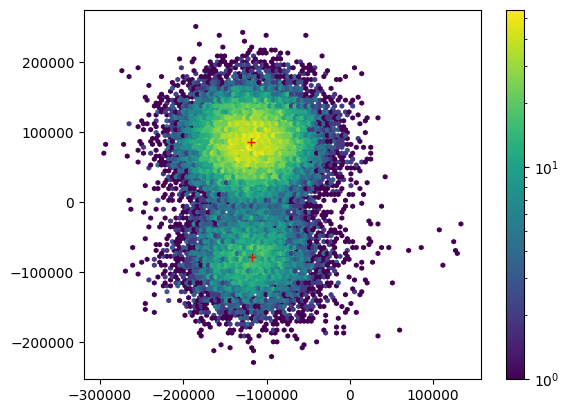

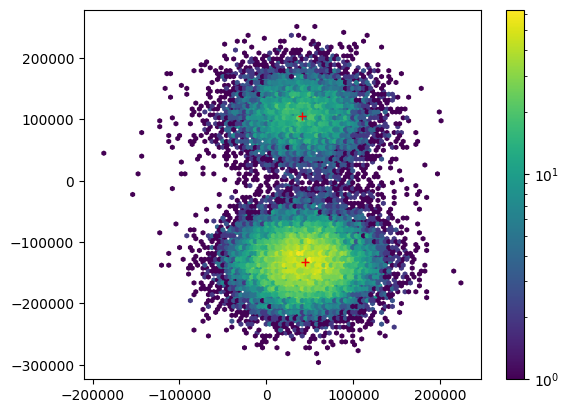

In [20]:
for q in qubits:
    l1=chevron.s11[str(channel_configs[q+'.rdrv'].core_ind)].reshape([-1,1])
    plt.hexbin(l1.real,l1.imag,bins='log')
    #plt.plot(l1.real,l1.imag,'.')
    c0=gmm.gmm_dict[q].gmmfit.means_[0]
    #c0=g.means_[0]
    plt.plot(c0[0],c0[1],'+',color='red')
    c1=gmm.gmm_dict[q].gmmfit.means_[1]
    #c1=g.means_[1]
    plt.plot(c1[0],c1[1],'+',color='red')
    plt.colorbar()
    plt.show()


In [21]:
from sklearn import mixture
l1iq=np.append(l1.real,l1.imag,1)
g=mixture.GaussianMixture(2,means_init=((11300,154641),(-100000,-200000)))
g.fit(l1iq)
print(g.means_)
print(g.weights_)

[[  40840.50440739  104724.36034667]
 [  43929.66563193 -131789.66054991]]
[0.26966816 0.73033184]


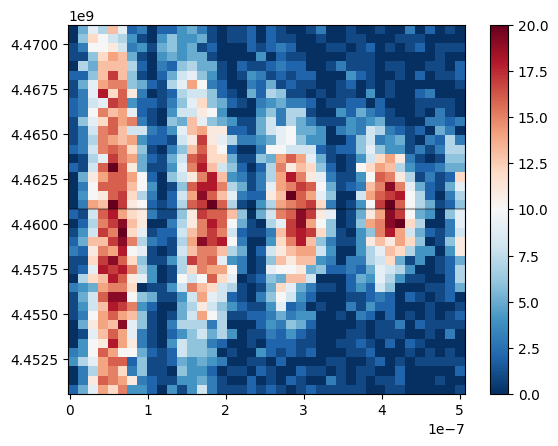

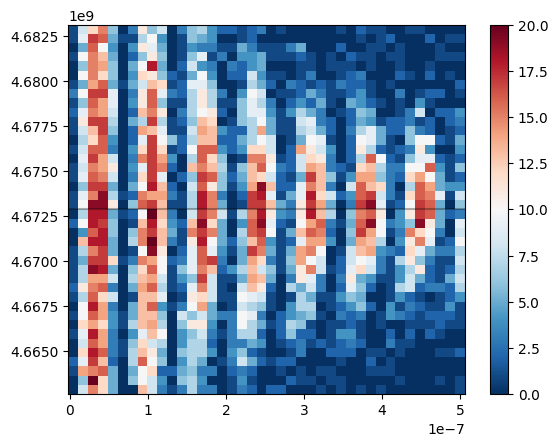

In [22]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
for q in qubits:
    y=qchip.qubits[q].freq
    plt.axhline(y=y,color='black',alpha=0.3)
    plt.pcolormesh(chevron.pulse_widths, chevron.centerfreq[q]+chevron.freqoffsets, ones_frac[q].T,cmap='RdBu_r')
    plt.colorbar()
    plt.show()

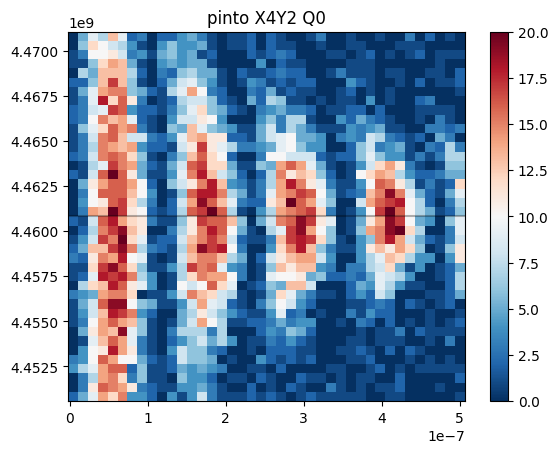

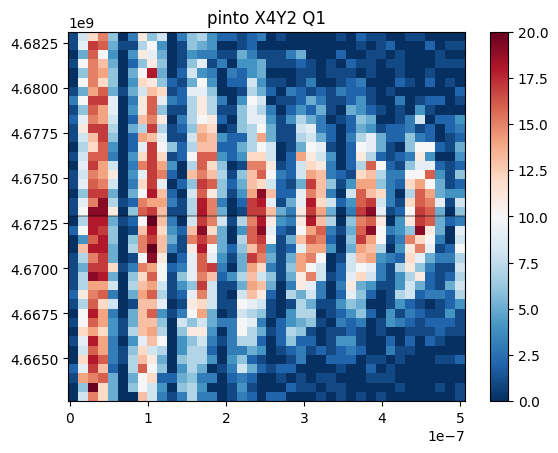

In [23]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
for q in qubits:
    plt.pcolormesh(chevron.pulse_widths, chevron.centerfreq[q]+chevron.freqoffsets, ones_frac[q].T,cmap='RdBu_r')
    plt.clim(0,nshot)
    plt.title('%s %s %s'%(board,str(chip),str(q)))
    y=qchip.qubits[q].freq
    plt.axhline(y=y,color='black',alpha=0.3)
    plt.colorbar()
    plt.show()

# Amplitude Rabi 

In [24]:
import chipcalibration.rabi_amp_sweep as rabiamp
reload(rabiamp)
qchip = qc.QChip(qchippath+'/qubitcfg.json')
#target_qubits = ['Q0', 'Q1', 'Q2', 'Q3']
qubits = ['Q0','Q1']
#qubits = ['Q0',]
target_twidth = 64e-9
num_partitions = 50
irabiamp = rabiamp.RabiAmpSweeper(qubits, target_twidth, qchip, fpga_config, channel_configs, num_partitions=num_partitions,rabigate='rabi_drag')
# fit is A*sin(2*pi*x/drive_period + phi) + B, params are [A, B, drive_period, phi]
prior_fit_params = {
    'Q0' : [-0.5, 0.5, 0.5, 0], 
    'Q1' : [-0.5, 0.5, 0.8, 0], 
}

In [25]:
irabiamp.run_and_fit(jobman, 100, prior_fit_params)

Taking data for qubit Q0 in batch 1 of 2
Taking data for qubit Q1 in batch 2 of 2


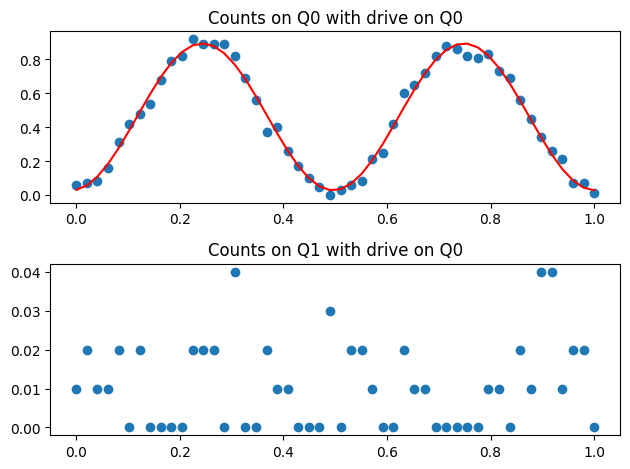

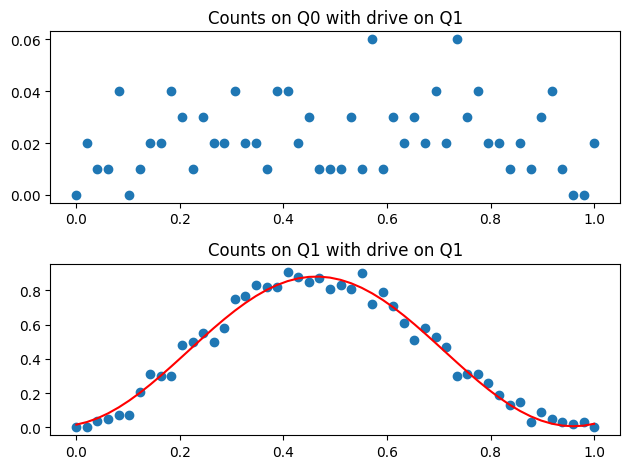

In [26]:
for q in qubits:
    irabiamp.show_count_oscillations(q, qubits, show_fits=True)

In [27]:
calibrated_X90_drive_amps = {qid: irabiamp.fits[qid][0][2]/4 for qid in qubits}
print(calibrated_X90_drive_amps)

{'Q0': 0.12631805661505957, 'Q1': 0.248140393746415}


In [28]:
if 0:
    irabiamp.update_qchip(qchip)
    qchip.save(qchippath+'/qubitcfg.json')

In [29]:
if 0:
    import qubic.state_disc as sd
    gmm = sd.GMMManager(chanmap_or_chan_cfgs=channel_configs)
    gmm.fit(irabiamp.all_raw_data)
jobman.update_gmm(irabiamp.gmm_manager)

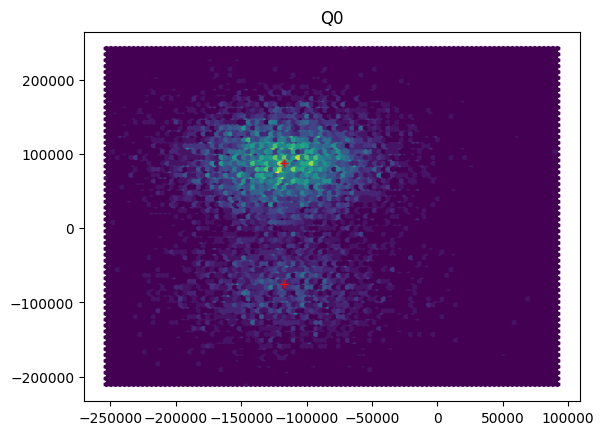

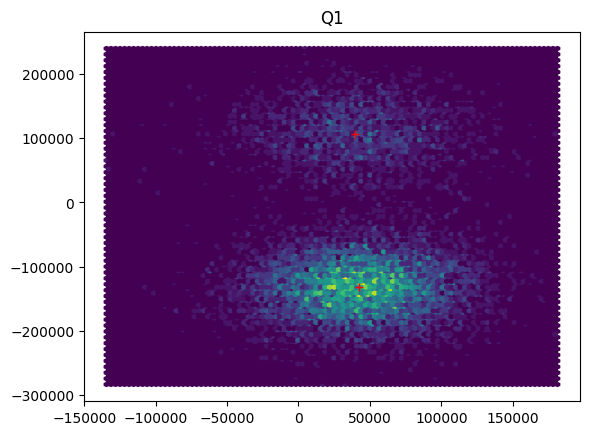

In [30]:
for q in qubits:
    core_ind=channel_configs[q+'.qdrv'].core_ind
    chval =irabiamp.all_raw_data[str(core_ind)]
    plt.hexbin(chval.real,chval.imag)
    plt.title(q)
    c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
    #c0=g.means_[0]
    plt.plot(c0[0],c0[1],'+',color='red')
    c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
    #c1=g.means_[1]
    plt.plot(c1[0],c1[1],'+',color='red')

    plt.show()
    


# Time Rabi

In [31]:
import chipcalibration.rabi_experiments as rabi_experiments
reload(rabi_experiments)
from chipcalibration.rabi_experiments import TimeRabi 

In [32]:
q='Q0'
taxis=np.linspace(0.e-9, 240e-9, 40)
irabitime = TimeRabi(target_qubit=[q], readout_register=[q], target_amplitude=calibrated_X90_drive_amps[q], pulse_width_interval=taxis,rabigate='rabi_drag')
 

In [33]:
irabitime.run_and_report(jobman, 100, qchip)

Could not fit with FFT, try again with a user defined period


TypeError: 'NoneType' object is not subscriptable

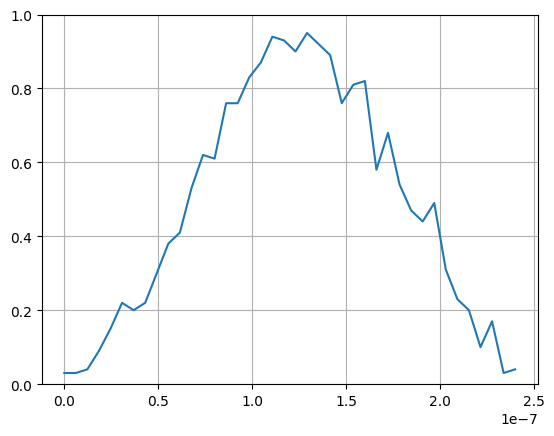

In [34]:
plt.plot(taxis,np.average(irabitime.shots[q], axis=1))
plt.ylim((0,1))
plt.grid()

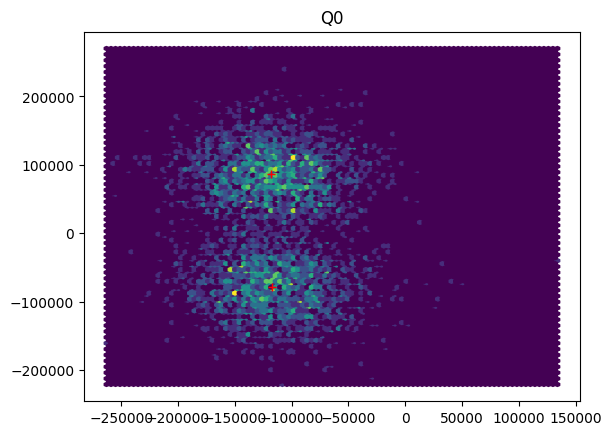

In [35]:
#for qubit in [q]:
if 1:    
    core_ind=channel_configs[q+'.qdrv'].core_ind
    #chval =rabi.shots[str(core_ind)]
    chval =irabitime.raw_IQ[str(core_ind)]
    plt.hexbin(chval.real,chval.imag)
    plt.title(q)
    c0=gmm.gmm_dict[q].gmmfit.means_[0]
    plt.plot(c0[0],c0[1],'+',color='red')
    c1=gmm.gmm_dict[q].gmmfit.means_[1]
    plt.plot(c1[0],c1[1],'+',color='red')
    plt.show()

# Ramsey

In [45]:
import chipcalibration.ramsey1 as ramsey
reload(ramsey)
from chipcalibration.ramsey1 import ramsey,ramsey_optimize
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q1'
delay_interval=np.linspace(0,100e-6,100)
#delay_interval=np.zeros(10)
framsey_offset=0;
iramsey=ramsey(qubit=q,delay_interval=delay_interval,qchip=qchip,framsey_offset=framsey_offset)

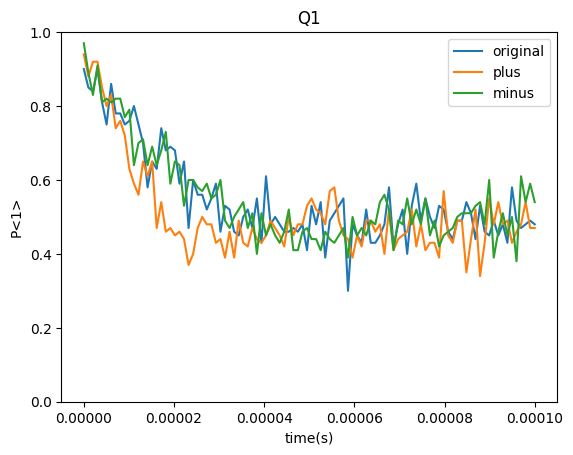

In [46]:
iramsey.plusminus(jobmanager=jobman,num_shots_per_circuit=100)

In [39]:
iramsey.update_qchip(qchip)
if 0:
    qchip.save(qchippath+'qubitcfg.json')

use the plus(p) or minus(m) or original(o) in the qubitcfg.json? or quit(q) q


In [40]:
p1=iramsey.run_and_report(jobmanager=jobman, num_shots_per_circuit=100)

(0.0, 1.0)

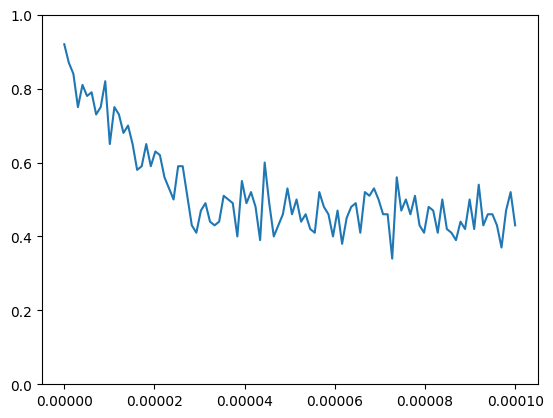

In [41]:
plt.plot(iramsey.delay_interval,iramsey.p1)
plt.ylim((0,1))

In [65]:
framsey_offsets=np.linspace(-200e3,200e3,6)
ramsop=ramsey_optimize(qubit=qubit,delay_interval=delay_interval,qchip=qchip,framsey_offsets=framsey_offsets,jobmanager=jobman,num_shots_per_circuit=100)
print(ramsop['absfit'][0][0])


-3305.634585827952


[212771.10362563428, 0.0, 227228.89637436572]

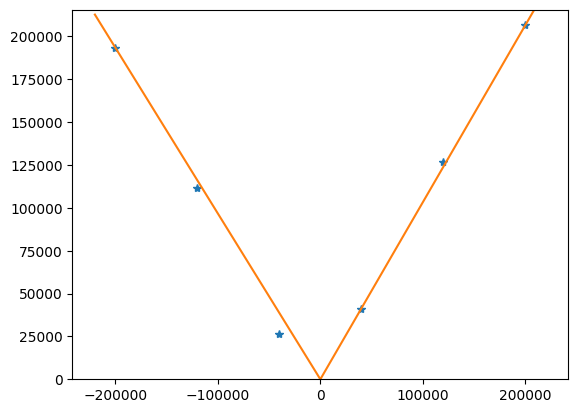

In [64]:
plt.plot(ramsop['x'],ramsop['y'],'*')
xlim=plt.gca().get_xlim()
ylim=plt.gca().get_ylim()
xplot=(xlim[0],0,xlim[1])
x0=ramsop['absfit'][0][0]
yplot=[abs(x-x0) for x in (xlim[0],x0,xlim[1])]
plt.plot(xplot,yplot)
plt.ylim((0,ylim[1]))

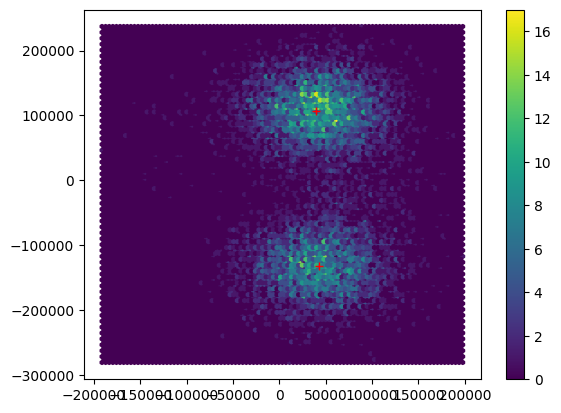

In [68]:
core_ind=str(channel_configs[q+'.qdrv'].core_ind)
plt.hexbin(iramsey.raw_IQ[core_ind].real,iramsey.raw_IQ[core_ind].imag)
plt.colorbar()
c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
plt.plot(c0[0],c0[1],'+',color='red')
c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
plt.plot(c1[0],c1[1],'+',color='red')

# Stack X90

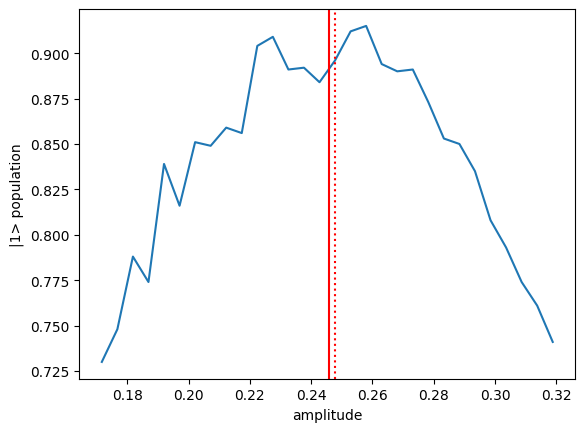

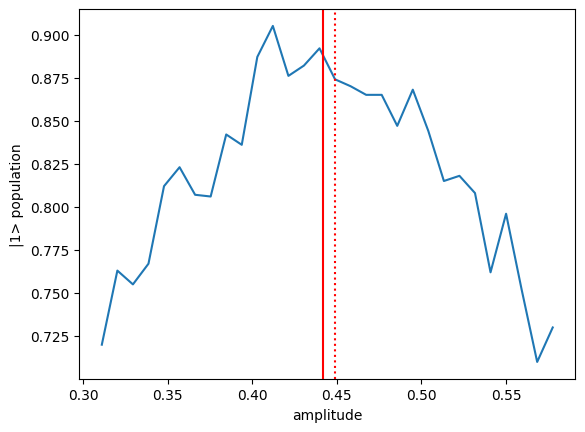

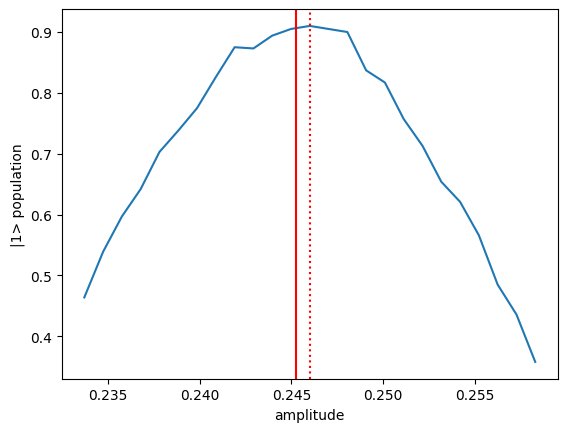

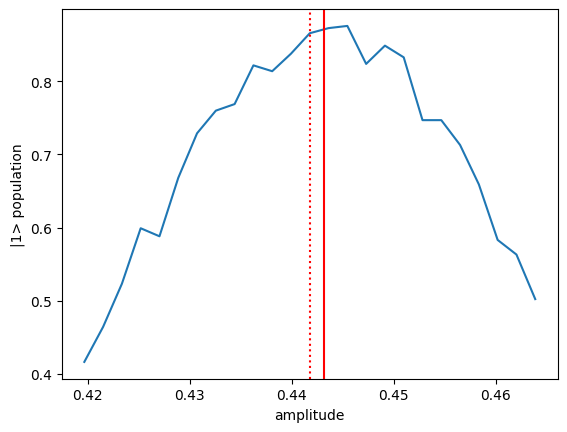

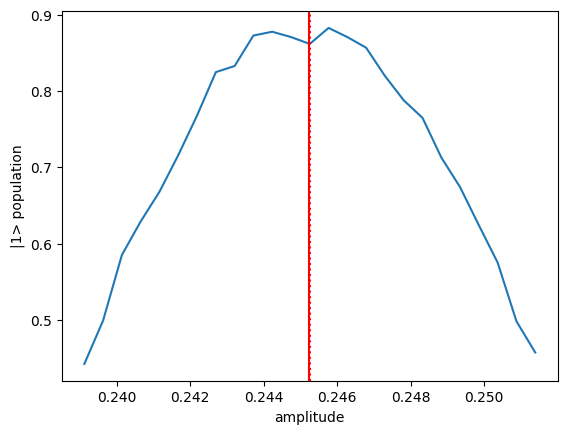

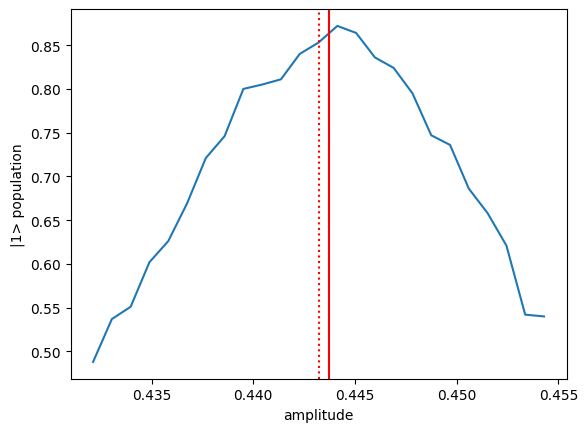

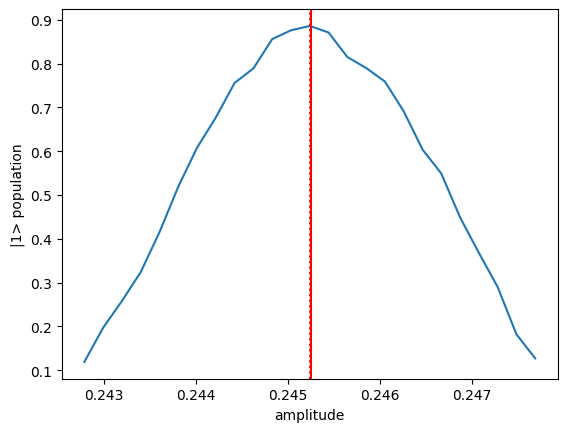

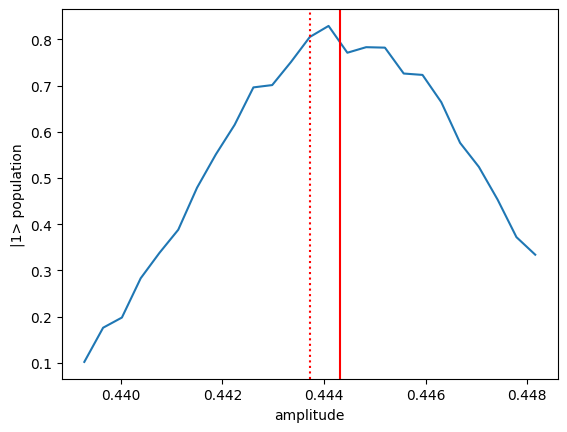

In [70]:
import chipcalibration.graph as graph
import chipcalibration.repeated_xgates as rx
reload(rx)
initratio=dict(Q0=0.3,Q1=0.3)
cal_graph = graph.CalibrationGraph()
for qubit in qubits:
    cal_graph.add_calibration_step('{}_stack_0'.format(qubit), 
                                   rx.XGateRepetition([qubit], initratio[qubit], 30, 0), 
                                   [qubit], shots_per_circuit=1000)
    cal_graph.add_calibration_step('{}_stack_1'.format(qubit), 
                                   rx.XGateRepetition([qubit], 0.05, 25, 5), 
                                   [qubit], predecessor_nodes=['{}_stack_0'.format(qubit)], shots_per_circuit=1000)
    cal_graph.add_calibration_step('{}_stack_2'.format(qubit), 
                                   rx.XGateRepetition([qubit], 0.025, 25, 10), 
                                   [qubit], predecessor_nodes=['{}_stack_1'.format(qubit)], shots_per_circuit=1000)
    cal_graph.add_calibration_step('{}_stack_3'.format(qubit), 
                                   rx.XGateRepetition([qubit], 0.01, 25, 40), 
                                   [qubit], predecessor_nodes=['{}_stack_2'.format(qubit)], shots_per_circuit=1000)
cal_graph.run_calibration(jobman, qchip, show_plots=True)    

In [71]:
if 0:
    qchip.save(qchippath+'qubitcfg.json')

# Drag alpha

In [72]:
import chipcalibration.dragalpha as dragalpha
reload(dragalpha)
from chipcalibration.dragalpha import dragalpha

qubit='Q0'
alphas=np.arange(-3,3,0.1)
idragalpha=dragalpha(qubit=qubit,alphas=alphas)


In [73]:
idragalpha.run_and_report(jobmanager=jobman,num_shots_per_circuit=1000,qchip=qchip)

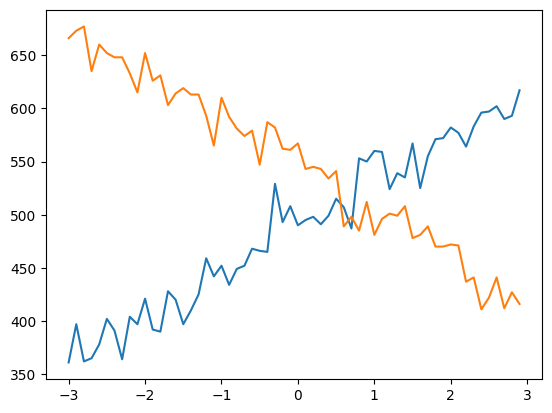

In [74]:
plt.plot(alphas,idragalpha.x90y180,label='x90y180')
plt.plot(alphas,idragalpha.y90x180,label='y90x180')

In [75]:
idragalpha.fit()

0.6665766718686161

In [76]:
idragalpha.update_qchip(qchip=qchip)
if 0:
    qchip.save(qchippath+'qubitcfg.json')

# Readout Frequency optimization by blob separation

In [80]:
import chipcalibration.blobfreq as blobfreq
reload(blobfreq)
from chipcalibration.blobfreq import blobfreq

qchip = qc.QChip(qchippath+'qubitcfg.json')
qubits=['Q0','Q1']
dfreads=np.linspace(-3e6,3e6,100)




In [81]:
blobres={}
for q in qubits:
    iblobfreq=blobfreq(qubit=q,dfreads=dfreads,qchip=qchip)
    blobres[q]=iblobfreq.run_and_report(jobmanager=jobman,num_shots_per_circuit=1000)

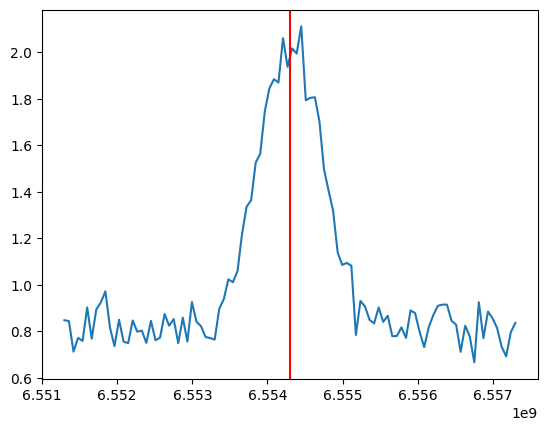

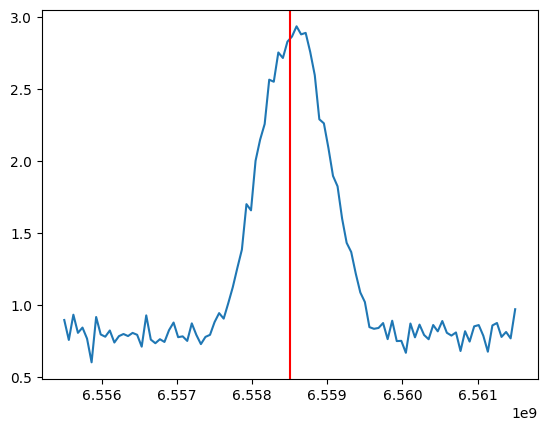

In [82]:
qchip = qc.QChip(qchippath+'/qubitcfg.json')
for q in qubits:
    plt.plot(blobres[q]['freads'],[d[(0,1)] for d in blobres[q]['dists']])
    plt.axvline(x=qchip.qubits[q].readfreq,color='red')
    plt.show()

# Single qubit Streamlined Randomized Benchmarking using TrueQ (SRB)

In [77]:
import trueq as tq
import qubic.trueq.transpiler as tp
import qubic.trueq.job_manager as tqj
jobman_tq = tqj.TrueQJobManager(fpga_config, qchip, channel_configs, runner, gmm_manager=jobman.gmm_manager)
tqcircuits = tq.make_srb(0, [4, 32, 128, 256], 20) #, compiled_pauli=False)
c=tqcircuits.append(tq.make_rcal(tqcircuits.labels))
#circuits = tq.make_srb(0, [4, 10, 50, 100, 200], 30)

In [78]:
def run_rb(qubit, circuits, nshots=1000):
    res = jobman_tq.build_and_run_circuits(circuits, [qubit], 1000, outputs=['counts', 'trueq_results'], 
                                    fit_gmm=False, delay_per_shot=0, delay_before_circuit=500.e-6)
    return res

Q0
Twirling with
Cliffords on [0]
---------------------------
SRB |Fit on Labels:       |
    |         (0,)        |
---------------------------
 A  | 1.02e+00 (4.88e-03) |
 p  | 9.99e-01 (5.31e-05) |
e_F | 4.56e-04 (3.98e-05) |
---------------------------

RCal Estimate on (0,):
---------------------------
 RCAL |     Confusion     |
---------------------------
      |  P(0|0) | P(1|1)  |
---------------------------
 (0,) |  0.965  | 0.874   |
---------------------------




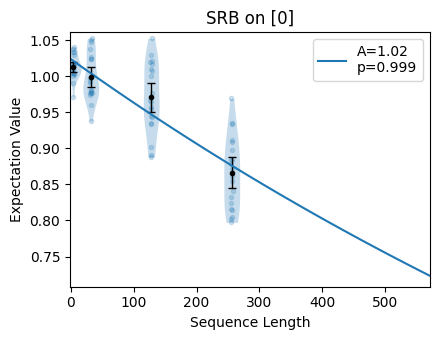

Q1
Twirling with
Cliffords on [0]
---------------------------
SRB |Fit on Labels:       |
    |         (0,)        |
---------------------------
 A  | 9.57e-01 (7.42e-03) |
 p  | 9.98e-01 (1.44e-04) |
e_F | 1.54e-03 (1.08e-04) |
---------------------------

RCal Estimate on (0,):
---------------------------
 RCAL |     Confusion     |
---------------------------
      |  P(0|0) | P(1|1)  |
---------------------------
 (0,) |  0.989  | 0.887   |
---------------------------




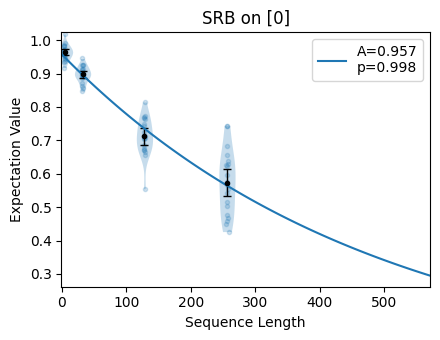

In [79]:
res={}
for q in qubits:
    print(q)
    res[q]=run_rb(qubit=q,circuits=tqcircuits)
    tqcircuits.results=res[q]['trueq_results']
    print(tqcircuits.fit())    
    tqcircuits.plot.raw()
    plt.show()

# Cross Resonance (CR) scan

## CR pulse length (twidth)

In [84]:
import chipcalibration.tcr as tcr
reload(tcr)


<module 'chipcalibration.tcr' from '/home/ghuang/qubic2_run/chipcalibration/chipcalibration/tcr.py'>

In [85]:
control_qubit='Q1'
target_qubit='Q0'
itcrtwidth = tcr.tcr(control_qubit=control_qubit,target_qubit=target_qubit)
twidths=np.linspace(100e-9,400e-9,20)
amps=[0.5,0.7,1.0]
itcrtwidth.cr_amp_width_sweep(twidths=twidths,amps=amps)

In [86]:
starttime=time.time()
c0,c1,r=itcrtwidth.run_and_report(jobmanager=jobman,num_shots_per_circuit=100,qchip=qchip)
print('time',time.time()-starttime)

time 30.58141851425171


(0.0, 1.0)

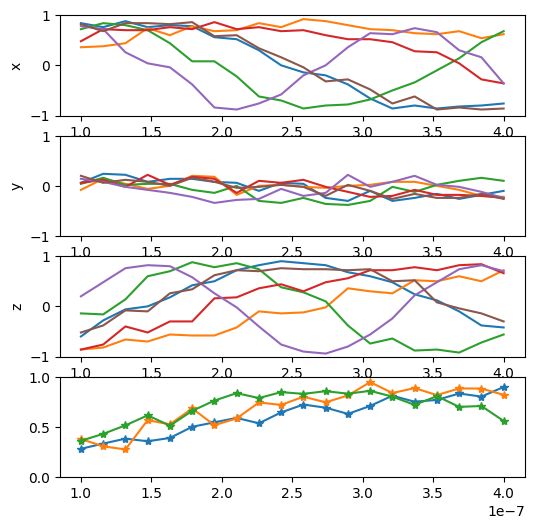

In [87]:
fig=plt.figure(figsize=(6,6))
ax=fig.subplots(4)
for itomo,tomo in enumerate(['x','y','z']):
    for iamp,amp in enumerate(amps):
        ax[itomo].plot(twidths,c0['Q0'][:,iamp,itomo],label='%s %8.2f'%('c0',amp))
        ax[itomo].plot(twidths,c1['Q0'][:,iamp,itomo],label='%s %8.2f'%('c1',amp))
        ax[itomo].set_ylabel(tomo)
        ax[itomo].set_ylim((-1,1))
    #ax[itomo].legend()
for iamp,amp in enumerate(amps):
    ax[3].plot(twidths,r['Q0'][:,iamp],'*-',label='%s %8.2f'%('r',amp))
#ax[3].legend()
ax[3].set_ylim((0,1))

## CR pulse amplitude

In [88]:
control_qubit='Q1'
target_qubit='Q0'
itcramp = tcr.tcr(control_qubit=control_qubit,target_qubit=target_qubit)
amps = np.linspace(0.08,0.980,31)
itcramp.cr_amp_sweep(amps=amps,repeat=1)


In [89]:
starttime=time.time()
c0,c1,r=itcramp.run_and_report(jobmanager=jobman,num_shots_per_circuit=100,qchip=qchip)
print('time',time.time()-starttime)

time 12.997387409210205


(0.0, 1.0)

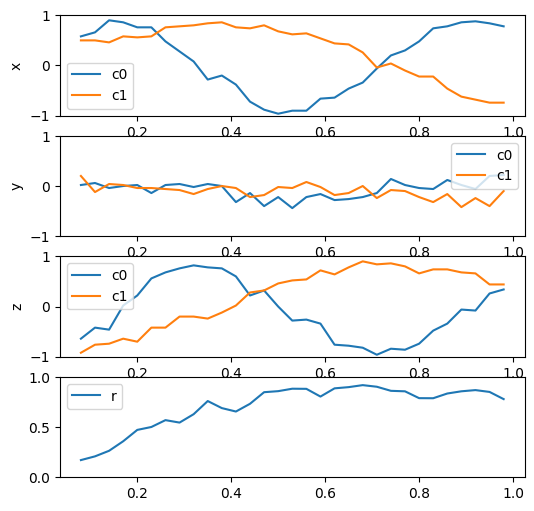

In [90]:
fig=plt.figure(figsize=(6,6))
ax=fig.subplots(4)
for itomo,tomo in enumerate(['x','y','z']):
    ax[itomo].plot(amps,c0['Q0'][0,:,itomo],label='%s'%('c0'))
    ax[itomo].plot(amps,c1['Q0'][0,:,itomo],label='%s'%('c1'))
    ax[itomo].set_ylabel(tomo)
    ax[itomo].set_ylim((-1,1))
    ax[itomo].legend()
ax[3].plot(amps,r['Q0'][0,:],label='%s'%('r'))
ax[3].legend()
ax[3].set_ylim((0,1))

In [ ]:
def quadratic(t,a,b,c):
    return a*(t-b)**2+c

0.7089009946427639


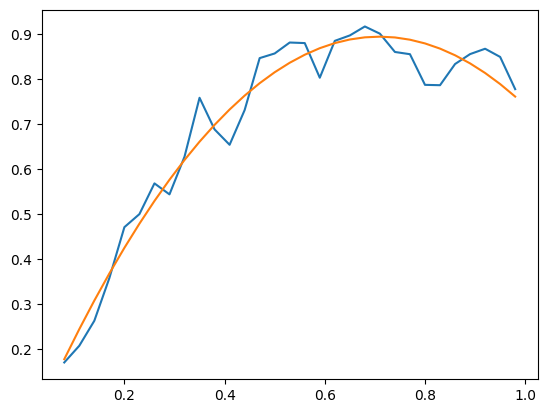

In [91]:
popt,pcov = curve_fit(quadratic,amps,r['Q0'][0,:])
rfit=quadratic(amps,*popt)
plt.plot(amps,r['Q0'][0,:])
plt.plot(amps, rfit, label='fit')    
print(popt[1])
if 0:
    qchip.gates['Q1Q0CR'].contents[0].amp=popt[1]
    qchip.gates['Q1Q0CNOT'].contents[1].amp=popt[1]
    qchip.save(qchippath+'/qubitcfg.json')

# Full XY scan

# fullxy scan search CNOT from CR

In [94]:
import chipcalibration.fullxycnot as fullxycnot
reload(fullxycnot)

zprepdeg = np.array([[246,147],[314,234],[336,37]])
zprepdeg = np.array([[246,147],[315,234],[335,37]])
#zprepdeg=np.random.rand(3,2)*360

zprep = zprepdeg/360*2*np.pi
xyrot = np.linspace(0,2*np.pi,200)
axes=('Y')
control_qubit = 'Q1'
target_qubit = 'Q0'

qchip = qc.QChip(qchippath+'qubitcfg.json')

ifullxy = fullxycnot.fullxycnot(control_qubit='Q1',target_qubit='Q0',xyrot=xyrot,zprep=zprep,axes=axes)


In [95]:
starttime=time.time()
ifullxy.run_and_report(jobmanager=jobman,num_shots_per_circuit=200,qchip=qchip)
print('time(s)',time.time()-starttime)

time(s) 29.81882071495056


{'pzctl': -0.011596501529120801,
 'pztgt': -0.05577956662632391,
 'pxtgt': -0.6470642997636926}

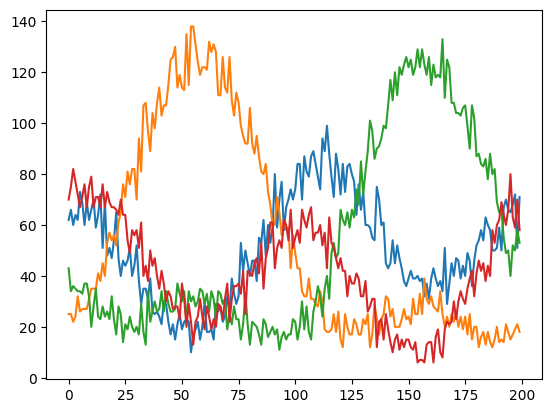

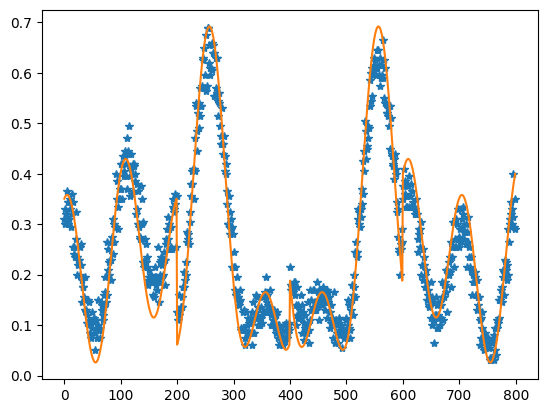

In [96]:
ifullxy.fit()

In [97]:
ifullxy.update_qchip(qchip)

In [98]:
qchip.save(qchippath+'qubitcfg.json')

# CNOT Truth table

In [174]:
import chipcalibration.cnottruthtable as cnottruthtable
reload(cnottruthtable)
control_qubit = 'Q1'
target_qubit = 'Q0'
qchip = qc.QChip(qchippath+'qubitcfg.json')
icnottruthtable = cnottruthtable.cnottruthtable(control_qubit=control_qubit,target_qubit=target_qubit)
icnottruthtable.truthcircuit(repeat=1)


In [176]:
print(icnottruthtable.run_and_report(jobmanager=jobman,num_shots_per_circuit=1000,qchip=qchip))

[[[0.954 0.033 0.003 0.01 ]
  [0.086 0.899 0.011 0.004]
  [0.024 0.07  0.097 0.809]
  [0.077 0.022 0.855 0.046]]]


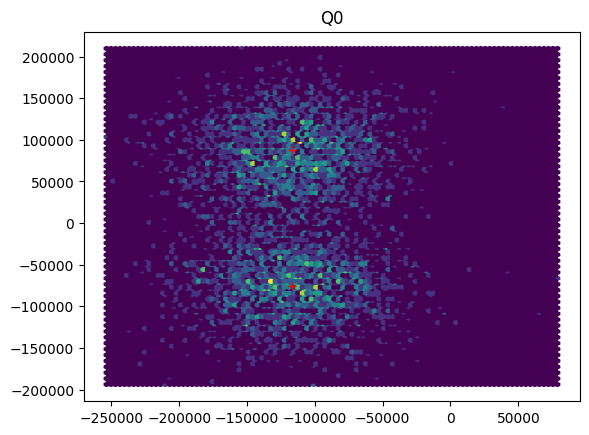

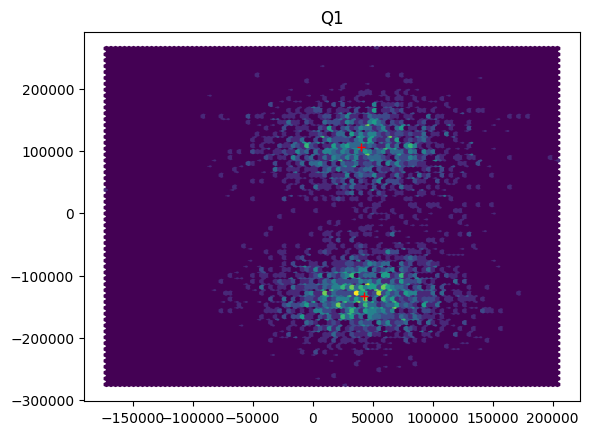

In [177]:
qubits=['Q0','Q1']
for q in qubits:
    plt.hexbin(icnottruthtable.output_dict['s11'][str(channel_configs[q+'.rdrv'].core_ind)].real,icnottruthtable.output_dict['s11'][str(channel_configs[q+'.rdrv'].core_ind)].imag)
    c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
    #c0=g.means_[0]
    plt.plot(c0[0],c0[1],'+',color='red')
    c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
    #c1=g.means_[1]
    plt.plot(c1[0],c1[1],'+',color='red')
    plt.title(q)
    plt.show()

## Try to optimize CNOT (not good yet)

In [103]:
import time
control = 'Q1'
target = 'Q0'

amps = np.linspace(0.66,0.725,21)
repeat = 10
widths = [350e-9]


In [ ]:
circuits=cr_sweep_amp_width(control_qubit=control,target_qubit=target,twidths=widths,amps=amps,repeat=repeat,crcnotgate='CNOT')
starttime=time.time()
shotsout=jobman.build_and_run_circuits(circuits, 1000, outputs=['shots'],reads_per_shot=len(amps)*6)['shots']
print('time',time.time()-starttime)

In [61]:

c0={}
c1={}
r={}
for k,v in shotsout.items():
    ss=np.average(v,axis=1).reshape((len(widths),len(amps),6))
    c0[k]=ss[:,:,:3]*2-1
    c1[k]=ss[:,:,3:]*2-1
    r[k]=0.5*np.sqrt(np.sum(np.square(c0[k]-c1[k]),axis=2))
    
#plt.legend()   

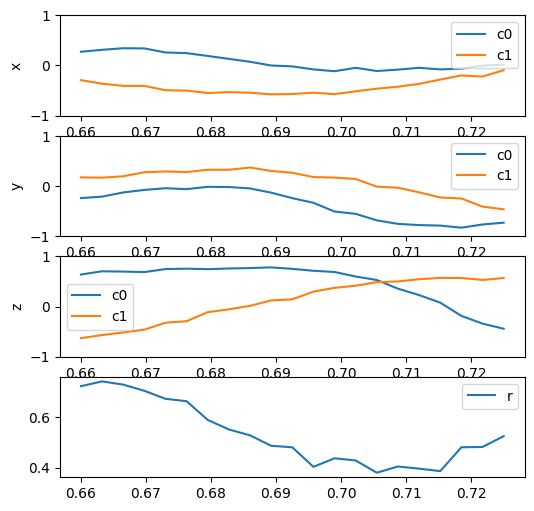

In [62]:
fig=plt.figure(figsize=(6,6))
ax=fig.subplots(4)
for itomo,tomo in enumerate(['x','y','z']):
    ax[itomo].plot(amps,c0['Q0'][0,:,itomo],label='%s'%('c0'))
    ax[itomo].plot(amps,c1['Q0'][0,:,itomo],label='%s'%('c1'))
    ax[itomo].set_ylabel(tomo)
    ax[itomo].set_ylim((-1,1))
    ax[itomo].legend()
ax[3].plot(amps,r['Q0'][0,:],label='%s'%('r'))
ax[3].legend()
#ax[3].set_ylim((0,1))

0.7055986977532032


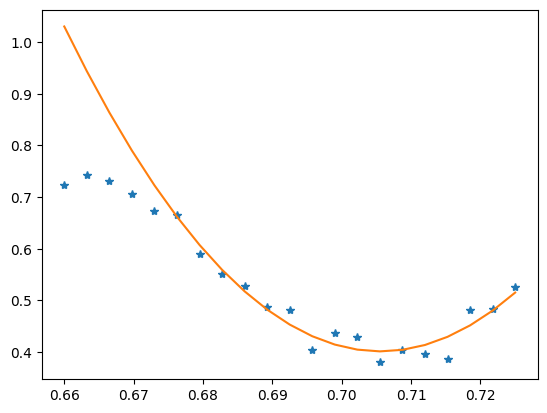

In [63]:
popt,pcov = curve_fit(quadratic,amps[5:],r['Q0'][0,:][5:])
rfit=quadratic(amps,*popt)
plt.plot(amps,r['Q0'][0,:],'*')
plt.plot(amps, rfit, label='fit')    
print(popt[1])

In [75]:
qchip.gates['Q1Q0CNOT'].contents[0].phase

2.136526256806759

In [12]:
twidth=qchip.gates['Q1Q0CNOT'].contents[1].twidth
amp=qchip.gates['Q1Q0CNOT'].contents[1].amp
deltapz=np.linspace(-0.1,0.1,21)
pztgts=qchip.gates['Q1Q0CNOT'].contents[0].phase+deltapz


pztgts=qchip.gates['Q1Q0CNOT'].contents[0].phase+deltapz
circuits=cnot_sweep_pztgt(control_qubit=control, target_qubit=target, twidth=twidth, amp=amp, pztgts=pztgts, repeat=1,crcnotgate='CNOT')



In [14]:
starttime=time.time()
shotsout=jobman.build_and_run_circuits(circuits, 1000, outputs=['shots'],reads_per_shot=len(pztgts)*6)['shots']
print('time',time.time()-starttime)

time 60.816333532333374


In [16]:
c0,c1,r=ccrk(shotsout,twidths=[twidth],amps=pztgts)

v (1, 1000, 126)
vavr (1, 126)
ss (1, 21, 6)
c0 (1, 21, 3)
c1 (1, 21, 3)
r (1, 21)
v (1, 1000, 126)
vavr (1, 126)
ss (1, 21, 6)
c0 (1, 21, 3)
c1 (1, 21, 3)
r (1, 21)


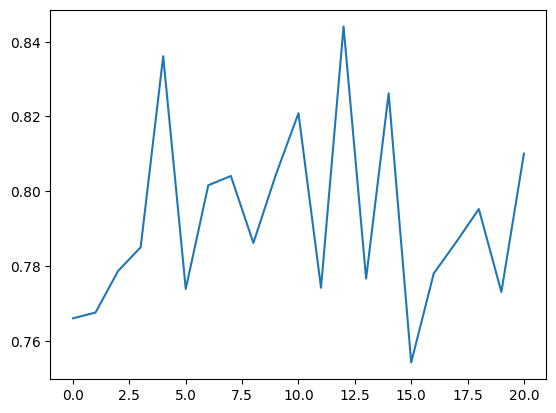

In [21]:
plt.plot(r['Q0'].flatten())

In [72]:
if 0:
    qchip.gates['Q1Q0CR'].contents[0].amp=popt[1]
    qchip.gates['Q1Q0CNOT'].contents[1].amp=popt[1]
    qchip.save(qchippath+'/qubitcfg.json')

# 2 qubits RB

Twirling with
Cliffords on [(0, 1)]
---------------------------
SRB |Fit on Labels:       |
    |        (0, 1)       |
---------------------------
 A  | 9.54e-01 (2.83e-02) |
 p  | 9.46e-01 (5.04e-03) |
e_F | 5.04e-02 (4.73e-03) |
---------------------------

RCal Estimate on (0, 1):
---------------------------
 RCAL |     Confusion     |
---------------------------
      |  P(0|0) | P(1|1)  |
---------------------------
 (0,) |  0.989  | 0.905   |
 (1,) |  0.979  | 0.891   |
---------------------------




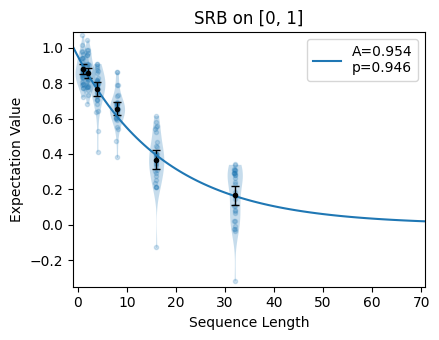

In [178]:
import trueq as tq
import qubic.trueq.transpiler as tp
import qubic.trueq.job_manager as tqj
jobman_tq = tqj.TrueQJobManager(fpga_config, qchip, channel_configs, runner, gmm_manager=jobman.gmm_manager)
#circuits = tq.make_srb([(0,1),], [1,2,4,8,16,32], 30)#, compiled_pauli=False)
circuits = tq.make_srb([(0,1),], [1,2,4,8,16,32], 30)#, compiled_pauli=False)
circuits.append(tq.make_rcal(circuits.labels))
qubit=['Q1','Q0']
res = jobman_tq.build_and_run_circuits(circuits, qubit, 1000, entangler='cnot', outputs=['counts', 'trueq_results'], 
                                    fit_gmm=False, delay_per_shot=0, delay_before_circuit=500.e-6)

circuits.results = res['trueq_results']
circuits.plot.raw()
print(circuits.fit())

# Save current GMM

In [ ]:
jobman.gmm_manager.save(qchippath+'Q01gmm.pkl')

# manual 0,1

In [486]:
qchip = qc.QChip(qchippath+'qubitcfg.json')
q='Q1'
tx=np.linspace(0,50e-6,100)
tx=np.zeros(30)
circuits= []
circuit=[]
df=-10e3
framsey=qchip.qubits[q].freq+df
for ti in tx:
#if 1:    
    circuit.append({'name': 'delay', 't': 400e-6, 'qubit': q})
#    circuit.append({'name': 'read', 'qubit': q})
#    circuit.append({'name': 'delay', 't': 12e-6, 'qubit': q})
    circuit.append({'name': 'X90', 'qubit': q,'modi':{(0,'freq'):framsey}})
    circuit.append({'name': 'delay', 't': ti, 'qubit': q})        
    circuit.append({'name': 'X90', 'qubit': q,'modi':{(0,'freq'):framsey}})
    
    circuit.append({'name': 'read', 'qubit': q})
circuits.append(circuit)

In [487]:
import time
tstart=time.time()
output_dict=jobman.collect_all(program_list=circuits,num_shots_per_circuit=200,reads_per_shot=len(tx),qchip=qchip)
print('time',time.time()-tstart)
raw_IQ=output_dict['s11']

time 3.023932456970215


In [488]:
if 0:
    jobman.gmm_manager.fit(raw_IQ)
predict=jobman.gmm_manager.predict(raw_IQ)

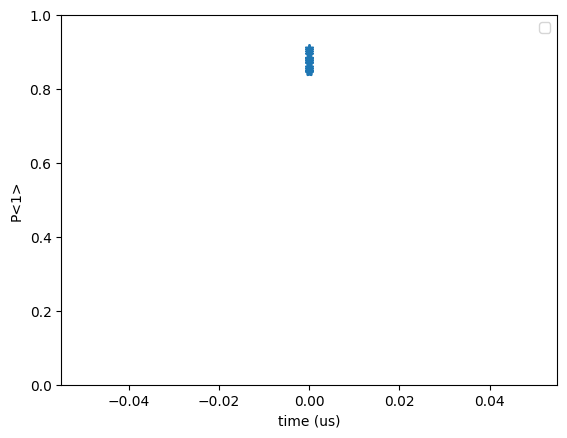

In [489]:
pd=predict[q].reshape((-1,len(tx)))
plt.plot(tx/1e-6,np.mean(pd,axis=0),'*-')
plt.xlabel('time (us)')
plt.ylabel('P<1>')
plt.ylim((0,1))
plt.legend()

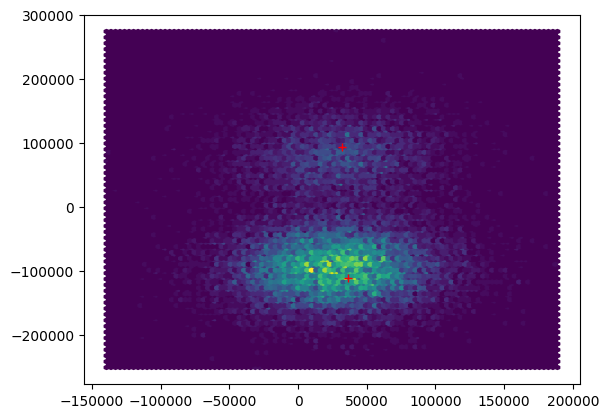

In [148]:
plt.hexbin(raw_IQ[str(channel_configs[q+'.rdrv'].core_ind)].real,raw_IQ[str(channel_configs[q+'.rdrv'].core_ind)].imag)
c0=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[0]
plt.plot(c0[0],c0[1],'+',color='red')
c1=jobman.gmm_manager.gmm_dict[q].gmmfit.means_[1]
plt.plot(c1[0],c1[1],'+',color='red')


[ 0.43067917  0.50424912  3.55723195 -0.19528887 15.03199363]
[ 4.30679168e-01  5.04249124e-01  3.55723195e+06 -1.95288870e-01
  1.50319936e-05]


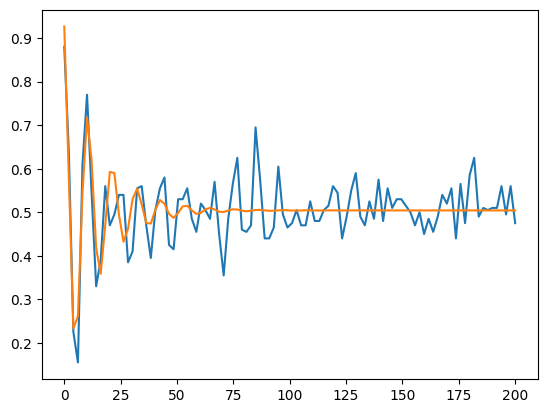

In [47]:
from scipy.optimize import curve_fit
k=1e-6
def _cos_exp(x, scale, offset, drive_freq, phi, exp_decay):
    return scale*np.exp(-x/exp_decay)*np.cos(2*np.pi*x*drive_freq - phi) + offset
fit = curve_fit(_cos_exp, tx/k, np.mean(pd,axis=0).flatten(),)
print(fit[0])
fit[0][2]=fit[0][2]/k
fit[0][4]=fit[0][4]*k
print(fit[0])
plt.plot(tx/1e-6,np.mean(pd,axis=0).flatten())
plt.plot(tx/1e-6,_cos_exp(tx,*fit[0]))
#plt.plot(tx/1e-6,np.cos(2*np.pi*10e3*tx),'.')
#plt.plot(tx/1e-6,np.cos(2*np.pi*1e6*tx),'.')
plt.show()

In [45]:
if 0:
    pall=predict['Q0'].reshape((-1,len(tx),2))
    ph=pall[:,:,0]
    pd=pall[:,:,1]
    plt.plot(tx/1e-6,np.sum((ph==0)*pd,axis=0)/np.sum(ph==0,axis=0),label='w/ harolding')
    plt.plot(tx/1e-6,np.mean(pd,axis=0),label='w/o harolding')
    plt.xlabel('time (us)')
    plt.ylabel('P<1>')
    plt.ylim((0,1))
    plt.legend()

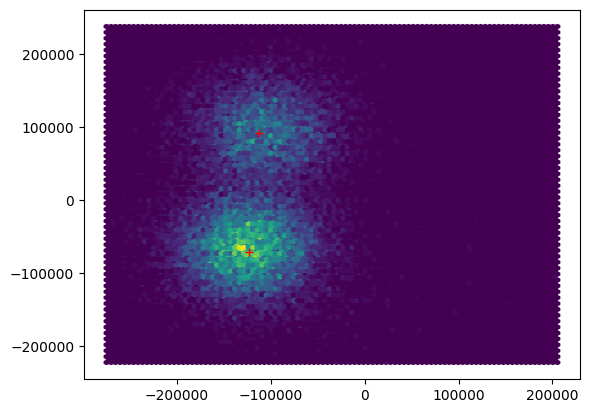

In [359]:
gmmfit=gmm.gmm_dict[q].gmmfit

In [334]:
gmmfit.means_

array([[ 59058.67405393,  60915.62835736],
       [-68525.91834094,  35033.23399699]])

In [321]:
gmmfit.means_[0]

array([59058.67405393, 60915.62835736])

In [344]:
for i,f in enumerate(iblobfreq.freads):
    print(i,f)

0 6555933028.9032955
1 6556248818.37698
2 6556564607.850664
3 6556880397.324348
4 6557196186.798033
5 6557511976.271716
6 6557827765.7454
7 6558143555.219085
8 6558459344.692769
9 6558775134.166453
10 6559090923.640138
11 6559406713.113822
12 6559722502.587506
13 6560038292.061191
14 6560354081.534875
15 6560669871.008558
16 6560985660.482243
17 6561301449.955927
18 6561617239.429611
19 6561933028.9032955


In [538]:
'Plus'.lower()

'plus'

# debug asm parse

In [383]:
import asmparse

In [51]:
iramsey.circuits

NameError: name 'iramsey' is not defined

In [92]:
jobman.raw_asm_progs[0]

{'7': {'cmd_buf': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\xa0|\x92\x00\x00z}\x08@\x00\xc0\x02\x00\x04\x08\x90\x80\x92\x92\x00 \xf6\x13\x08@\x00\x00\x02\x00\xfa\x08\x90\x00\xb8\x92\x00@\xfe\xff\t\xc0S<\x02\x00\xfa\x08\x90\x00\xb1%\x01\x00z}\x08@\x00\x00\x02\x00\x04\x08\x90\xe0\xc6%\x01 \xf6\x13\x08@\x00\x00\x02\x00\xfa\x08\x90`\xec%\x01@\xfe\xff\t\xc0S<\x02\x00\xfa\x08\x90@\xfb\xb8\x01 \xf6\x13\x08@\x00\x00\x02\x00\xfa\x08\x90\xc0 \xb9\x01@\xfe\xff\t\xc0S<\x02\x00\xfa\x08\x90\xc0\x1dL\x02\x00z}\x08@\x00\xc0\x02\x00\x04\x08\x90\xa03L\x02 \xf6\x13\x08@\x00\x00\x02\x00\xfa\x08\x90 YL\x02@\xfe\xff\t\xc0S<\x02\x00\xfa\x08\x90 V\xdf\x02\x00z}\x08@\x00\x00\x02\x00\x04\x08\x90\x00l\xdf\x02 \xf6\x13\x08@\x00\x00\x02\x00\xfa\x08\x90\x80\x91\xdf\x02@\xfe\xff\t\xc0S<\x02\x00\xfa\x08\x90`\xa4r\x03 \xf6\x13\x08@\x00\x00\x02\x00\xfa\x08\x90\xe0\xc9r\x03@\xfe\xff\t\xc0S<\x02\x00\xfa\x08\x90\xe0\xc2\x05\x04\x00z}\x08@\x00\xc0\x02\x00\x04\x08\x90\xc0\xd8\x05\x04 \xf6\x13\x08@\x

In [385]:
asmparse.cmdparse(jobman.raw_asm_progs[-1]['7']['cmd_buf'])

opcode=10110,cmdtime=00000000,cfg=0,amp=0000,freq=00000,phase=00000,env_start=000,env_length=000
opcode=10010,cmdtime=000493e5,cfg=0,amp=1f61,freq=00000,phase=0d111,env_start=000,env_length=010
opcode=10010,cmdtime=000493f5,cfg=0,amp=1f61,freq=00000,phase=01ddd,env_start=000,env_length=010
opcode=10010,cmdtime=000494f3,cfg=0,amp=2a27,freq=00000,phase=0527d,env_start=000,env_length=010
opcode=10010,cmdtime=00049503,cfg=0,amp=1f61,freq=00000,phase=0527d,env_start=000,env_length=010
opcode=10010,cmdtime=00049513,cfg=1,amp=04fd,freq=00000,phase=00000,env_start=000,env_length=3e8
opcode=10010,cmdtime=0004963f,cfg=2,amp=7fff,freq=00000,phase=078a7,env_start=000,env_length=3e8
opcode=10100,cmdtime=00000000,cfg=0,amp=0000,freq=00000,phase=00000,env_start=000,env_length=000


In [386]:
asmparse.cmdparse(jobman.raw_asm_progs[0]['4']['cmd_buf'])

opcode=10110,cmdtime=00000000,cfg=0,amp=0000,freq=00000,phase=00000,env_start=000,env_length=000
opcode=10010,cmdtime=000493e5,cfg=0,amp=6ff6,freq=00000,phase=15ddd,env_start=000,env_length=010
opcode=10010,cmdtime=000493f5,cfg=0,amp=6ff6,freq=00000,phase=11c71,env_start=000,env_length=010
opcode=10010,cmdtime=00049405,cfg=0,amp=7665,freq=00001,phase=1e782,env_start=010,env_length=0ee
opcode=10010,cmdtime=00049503,cfg=0,amp=6ff6,freq=00000,phase=0d389,env_start=000,env_length=010
opcode=10010,cmdtime=00049513,cfg=1,amp=047a,freq=00000,phase=00000,env_start=000,env_length=3e8
opcode=10010,cmdtime=0004963f,cfg=2,amp=7fff,freq=00000,phase=00000,env_start=000,env_length=3e8
opcode=10100,cmdtime=00000000,cfg=0,amp=0000,freq=00000,phase=00000,env_start=000,env_length=000


In [93]:
for e in jobman.raw_asm_progs:
    env=asmparse.envparse(e['7']['env_buffers'][0])
    plt.plot(env.real,'r')
    plt.plot(env.imag,'b')




NameError: name 'asmparse' is not defined

In [57]:
jobman.raw_asm_progs[0]['7']['freq_buffers']

[b'>\xaf\xf0\xeb\xae\xd2L\x88\xc5T\xe7_\xc4\x8eS\xc4\x07\x7f\xb7\x0f\xa3\x83H\x1e\x96i\xa6\xb7\xe0\xb6\ri1\x1f\xdd\x83\xc9\x0e$\x7f(\xc5U\x8eG_xU\xa2\x88\xce\xd1\xfe\x7f\xf0\x00\xf8\x87q,\x85`\xf0\xab',
 b'_\xd0C\x1a\xd1\x8b\xb55\x80\x9e\x12\xad^"\xb4\x84V~v\xeb\xa7G\x10j\xcb\xbd\x8bm\xc9\x80\xdd\xf1u\xd7\x98\x860]B\xa8\xbfv\xc6/v\x06\xd5\x7f\xad\x8e\x80;q\x9a\x19\xb2\x1a\x1c \x83$}\x1d\xe5\xf9\xc1K\x1a\xd2\x8b\xb65~\x9e\x15\xadY"\xb3\x84U~p\xeb\xaeG\x0bj\xd3\xbd\x90m\xc8\x80\xe8\xf1i\xd7\x9c\x86\']8\xa8\xc5v\xb8/\x87\x06\xd4\x7f\xb5\x8e\x91;d\x9a)\xb2\x04\x1c\x1c\x83\x1f}\x06\xe5\x93\xb3S\x1a\xd2\x8b\xb75|\x9e\x17\xadU"\xb2\x84T~j\xeb\xb4G\x07j\xdb\xbd\x94m\xc7\x80\xf3\xf1]\xd7\xa0\x86\x1d]-\xa8\xcbv\xa9/\x98\x06\xd3\x7f\xbe\x8e\xa1;X\x9a9\xb2\xef\x1b\x17\x83\x1a}\xef\xe4-\xa5[\x1a\xd3\x8b\xb95z\x9e\x1a\xadP"\xb0\x84S~d\xeb\xbaG\x02j\xe3\xbd\x99m\xc6\x80\xfe\xf1Q\xd7\xa4\x86\x13]#\xa8\xd1v\x9b/\xa9\x06\xd3\x7f\xc7\x8e\xb2;L\x9aI\xb2\xda\x1b\x12\x83\x15}\xd8\xe4\xc7\x96c\x1a\xd3\x8b\xb

[460.82065231]


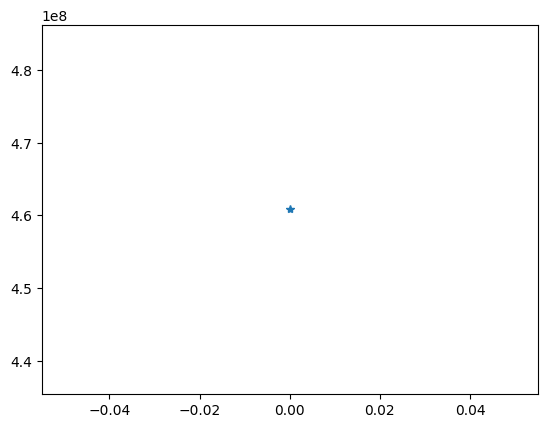

In [60]:
fp=asmparse.freqparse(jobman.raw_asm_progs[0]['7']['freq_buffers'][0])
freq=fp['freq']
fiq=fp['iq15']
plt.plot(freq,'*')
print(freq/1e6)

In [61]:
fp

{'freq': array([4.60820652e+08]),
 'iq15': array([[-30644.-11602.j,  24551.+21701.j, -15277.-28988.j,
           4023.+32519.j,   7752.-31837.j, -18522.+27030.j,
          26893.-18720.j, -31779. +7985.j,  32548. +3785.j,
         -29099.-15064.j,  21880.+24391.j, -11826.-30558.j,
            240.+32766.j,  11377.-30728.j, -21520.+24709.j]])}

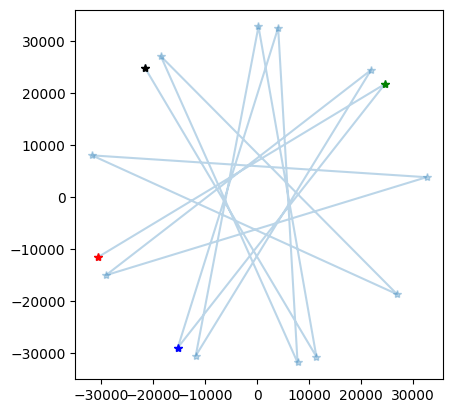

In [62]:
i=0
plt.plot(fiq[i].real,fiq[i].imag,'*-',alpha=0.3)
plt.plot(fiq[i][0].real,fiq[i][0].imag,'r*')
plt.plot(fiq[i][1].real,fiq[i][1].imag,'g*')
plt.plot(fiq[i][2].real,fiq[i][2].imag,'b*')
plt.plot(fiq[i][-1].real,fiq[i][-1].imag,'k*')
plt.gca().set_aspect('equal')